## Remapped force constants

In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from ase.io import read

from hilde.trajectory import reader
from hilde.harmonic_analysis.displacements import get_dR

from hilde.harmonic_analysis.force_constants import parse_tdep_forceconstant

In [2]:
fc = parse_tdep_forceconstant('outfile.forceconstant_remapped')
primitive = read('infile.ucposcar', format='vasp')
supercell = read('infile.ssposcar', format='vasp')

Parse force constants from
  outfile.forceconstant_remapped
.. Number of atoms:   64
.. Real space cutoff: 3.660 \AA
.. time elapsed: 0.022s


In [3]:
trajectory = reader('trajectory.yaml')

.. trajectory.yaml parsed in 1.073s


In [4]:
force_shape = trajectory[0].get_forces().shape

In [5]:
forces_dft = np.array([a.get_forces().flatten() for a in trajectory])

In [6]:
forces_harmonic = np.array([-fc @ get_dR(supercell, a).flatten() for a in trajectory])

In [7]:
forces_dft_mean = np.mean(forces_dft, axis=0)
forces_harmonic_mean = np.mean(forces_harmonic, axis=0)

## R^2

https://en.wikipedia.org/wiki/Coefficient_of_determination#Comparison_with_norm_of_residuals

In [8]:
def R2(f1, f2):
    f1_mean = np.mean(f1, axis=0)
    f2_mean = np.mean(f2, axis=0)
    Sres = (f1 - f2) @ (f1 - f2)
    Stot = (f1 - f1_mean) @ (f1 - f1_mean)
    
    return 1 - Sres / Stot

In [9]:
def Chi2(f1, f2):
    return (f1 - f2) @ (1 / f2) / len(f1)

In [10]:
def pearson(f1, f2):
    s1 = f1.std()
    s2 = f2.std()
    
    f = (f1 - f1.mean()) @ (f2 - f2.mean())
    
    return f / s1 / s2

In [11]:
r2 = R2(forces_harmonic.flatten(), forces_dft.flatten()) * 100
f'R^2 = {np.mean(r2):.2f} +/- {np.std(r2):.2f}'

'R^2 = 93.05 +/- 0.00'

In [12]:
r2 = R2(forces_dft.flatten(), forces_harmonic.flatten()) * 100
f'R^2 = {np.mean(r2):.2f} +/- {np.std(r2):.2f}'

'R^2 = 93.51 +/- 0.00'

In [13]:
forces_dft.shape

(2000, 192)

In [14]:
pearson(forces_dft.flatten(), forces_harmonic.flatten())

371331.9301460494

# 1D representation

In [16]:
f_dft = forces_dft.copy().reshape([-1, *force_shape])
f_ha = forces_harmonic.copy().reshape([-1, *force_shape])

# normalize forces

# norm = la.norm(f_dft, axis=(1, 2))[:, None, None]
norm = np.sqrt((f_dft**2).sum(axis=(1, 2)).mean())


f_dft /= norm
f_ha /= norm

norm

10.760550287036551

In [17]:
# x, y, z components
for i in range(3):
    print(R2(f_dft[:, :, i].flatten(), f_ha[:, :, i].flatten()))

0.9338795319391506
0.9343331447067024
0.9372080475649908


In [18]:
def set_label(ax, xlabel=None, ylabel=None, rotation=0):
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, rotation=rotation)
    
def set_square(ax, lim, line=True, **kwargs):
    ax.set_aspect(1)

    lims = [-lim, lim]

    ax.set_xlim(lims)
    ax.set_ylim(lims)

    if line:
        ax.plot(lims, lims, **kwargs)
        
def set_fontsize(ax, fontsize):
    ax.set_xlabel(ax.get_xlabel(), size=fontsize)
    ax.set_ylabel(ax.get_ylabel(), size=fontsize, rotation=0)
    # ax.yaxis.set_label_coords(-.22, .41)
    # ax.legend(ax.legend(), fontsize=fontsize)

    ax.tick_params(labelsize=fontsize-2)

In [19]:
# https://artsexperiments.withgoogle.com/artpalette/colors/212e43-b82c4a-761d46-642f7c-cc1e23
# https://artsexperiments.withgoogle.com/artpalette/colors/1f1916-f1e4d6-b5483f-959179-efab2d
c0 = '#2a2b2a'
c1 = '#1f1916'
c2 = '#f1e4d6'
c3 = '#b5483f'
c4 = '#959179'
c5 = '#efab2d'

In [20]:
# https://artsexperiments.withgoogle.com/artpalette/colors/363639-dcceb9-a82935-5e755a-e2ad1e
cs = [
    '#363639',
    '#a82935',
    '#dcceb9',
    '#e2ad1e',
    '#5e755a',
]

In [21]:
f_dft_label = '$F^{\mathrm{DFT}}$'
f_ha_label = '$F^{\mathrm{ha}}$'

In [22]:
f_ha[:, np.array(supercell.get_chemical_symbols()) == 'I', 0].flatten()

array([], dtype=float64)

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))

n_steps = 50

ii = 0

symbols = np.array(supercell.get_chemical_symbols())

labels = ['Mg', 'O']

for nn, label in enumerate(labels):
    df = pd.DataFrame()
    df[f'x'] = f_ha[:n_steps, symbols == label, ii].flatten()
    df[f'y'] = f_dft[:n_steps, symbols == label, ii].flatten()

    df.plot(x='x', y='y', ax=ax, marker='o', ls='', color=cs[nn], alpha=.9, ms=15)

f_dft_label = '$\mathbf{F}^{\mathrm{DFT}}$'
f_ha_label = '$\mathbf{F}^{\mathrm{ha}}$ / ' + f'{norm:.2f}' #$[\mathrm{eV} / \mathrm{\AA}$]'

set_label(ax, f_ha_label, f_dft_label)
lim = 0.33
set_square(ax, lim, lw=3.5, ls='--', c=cs[4])

fsize = 27
set_fontsize(ax, fsize)

ax.set_title('MgO at 600K', fontsize=fsize, y=1.04)

ax.xaxis.set_label_coords(.55, -.15)
ax.yaxis.set_label_coords(-.15, .52)

# ax.axes.margins(1)

fig.subplots_adjust(bottom=.2, left=.2)

ax.legend(labels, fontsize=20)

#ax.xaxis.set_ticks(np.arange(-2, 2+.01, 1))
#ax.yaxis.set_ticks(np.arange(-2, 2+.01, 1))

ax.text(0.05, -0.275, f'$r^2$ = {r2/100:.2f}', fontsize=fsize, weight='bold')

fig.savefig('dft_vs_ha_xyz.png', dpi=300)

In [27]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)

n_steps = 100

ii = 0

symbols = np.array(supercell.get_chemical_symbols())

labels = ['O', 'Mg']

dfs = []
for ii, sym in enumerate(labels):
    df = pd.DataFrame()
    x = f_ha[:n_steps, symbols == sym, ii].flatten()
    df[f'x'] = x
    df[f'y'] = f_dft[:n_steps, symbols == sym, ii].flatten()
    dfs.append(df)

    df.plot(x='x', y='y', ax=axs[ii], marker='o', ls='', color=cs[ii], alpha=.9, ms=12)

# ax.set_title('DFT vs. HA')
# ax.legend().remove()

set_label(axs[0], f_ha_label, f_dft_label)
set_label(axs[1], xlabel=f_ha_label)
set_square(axs[0], 1, lw=3, ls='--')
set_square(axs[1], 1, lw=3, ls='--', c=c1)


set_fontsize(axs[0], 20)
set_fontsize(axs[1], 20)

# ax.yaxis.set_label_coords(-.22, .41)

axs[0].legend([labels[0]], fontsize=20)
axs[1].legend([labels[1]], fontsize=20)

fig.tight_layout()

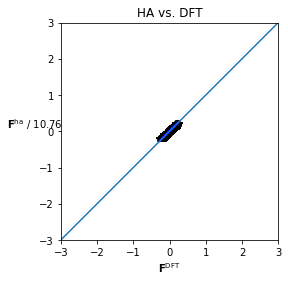

In [25]:
fig, ax = plt.subplots()

y = f_ha[:n_steps, :, 0]
x = f_dft[:n_steps, :, 0]

ax.plot(x, y, '*k')
ax.plot(x, x, 'b')

ax.set_title('HA vs. DFT')

set_square(ax, 3)
set_label(ax, f_dft_label, f_ha_label)